# IEOR 165 Final Project

The authors of the following research paper: Cortez, A. Cerdeira, F. Almeida, T. Matos, and J. Reis, “Modeling wine preferences by data mining from physicochemical properties”,Decision Support Systems, vol. 47, no. 4:547-553, 2009. considered  the  problem  of  modeling  wine  preferences.   

Wine can be evaluated by experts who give a subjective score, and the question the authors of this paper considered was how to build a model that relates objective features of the wine (e.g. pH values) to its rated quality.

For this project, we will use the data set available at: http://courses.ieor.berkeley.edu/ieor165/homeworks/winequality-red.csv 

Use the following methods to identify the coefficients of a linear model relating wine quality to different features of the wine: (1) ordinary least squares (OLS), (2) ridge regression (RR), (3) lasso regression, (4) elastic net. Make sure to include a constant (intercept) term  in  your model, and choose the tuning parameters using cross-validation. You may use any programming language you would like to. For your solutions, please include (i) plots of tuning parameters versus cross-validation error, (ii) tables of coefficients (labeled by the feature) computed by eachmethod, (iii) the minimum cross-validation error for each method, and (iv) the source code used to generate the plots and coefficients.

In [394]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import re
import seaborn as sns
from scipy import stats
import sklearn
import sklearn.datasets
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.linear_model import ElasticNet

# Loading Wine Data
Loading the data and splitting it into the predictor variables or features (X) and the response variable quality score (Y).
We then need to split the data into training and testing data so that we know how well our model is at predicting.

In [364]:
wine_data = pd.read_csv("winequality-red.csv")
wine_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [365]:
X = wine_data.iloc[:, 0:11]
Y = wine_data.iloc[:,11]

In [366]:
#adding the ones for the intercept term
X['intercept']=np.ones(len(X))
cols = X.columns.tolist()
cols = cols[-1:] + cols[:-1]
X = X[cols]
X

,intercept,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,1.0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
1,1.0,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8
2,1.0,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8
3,1.0,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
4,1.0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,1.0,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5
1595,1.0,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2
1596,1.0,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0
1597,1.0,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2


In [367]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.10)

# Rough EDA

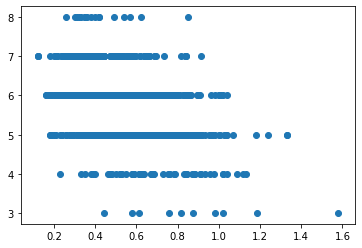

In [368]:
plt.scatter(X.iloc[:,2], Y)

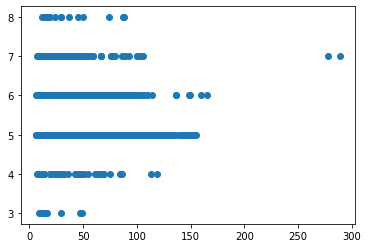

In [369]:
plt.scatter(X.iloc[:,7], Y)

# Ordinary Least Squares Model
Given by argmin(($ ||Y - Xbeta||^2_2)$and without any regularization.

I am using scikit learn machine learning library built in linear regression model fitting.

"LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation."
    From: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [376]:
#fitting the model without built in intercept
ordinary_linear_model = linear_model.LinearRegression(fit_intercept=False)

ordinary_linear_model.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [378]:
ols_coef = ordinary_linear_model.coef_
ols_coef

array([ 2.19652085e+01,  2.49905527e-02, -1.08359026e+00, -1.82563948e-01,
        1.63312698e-02, -1.87422516e+00,  4.36133331e-03, -3.26457970e-03,
       -1.78811638e+01, -4.13653144e-01,  9.16334413e-01,  2.76197699e-01])

In [148]:
predictions = linear_model.predict(X)
predictions = np.around(predictions, decimals=0)
predictions = predictions.astype(int)
predictions

array([5, 5, 5, ..., 6, 5, 6])

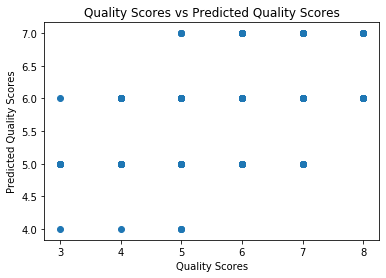

In [149]:
#not very good
plt.scatter(Y, predictions)
plt.xlabel("Quality Scores")
plt.ylabel("Predicted Quality Scores")
plt.title("Quality Scores vs Predicted Quality Scores");

In [150]:
ols_percent = sum(predictions==Y)/len(Y)*100
ols_percent

59.161976235146966

# Ridge Regression

   Given by argmin $ ||y - Xbeta||^2_2 + alpha * ||beta||^2_2 $ where alpha is the tuning parameter we will be finding using cross validation to minimize prediction error.

I am using scikit learn machine learning library built in ridge regression model fitting.

"This model solves a regression model where the loss function is the linear least squares function and regularization is given by the l2-norm." From: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge

In [339]:
ridge_linear_model = Ridge(fit_intercept = False, alpha=.08)
ridge_linear_model.fit(X,Y)
ridge_coef = ridge_linear_model.coef_

In [340]:
ridge_predictions = ridge_linear_model.predict(X)
ridge_predictions = np.around(ridge_predictions, decimals=0)
ridge_predictions = ridge_predictions.astype(int)
ridge_predictions

array([5, 5, 5, ..., 6, 5, 6])

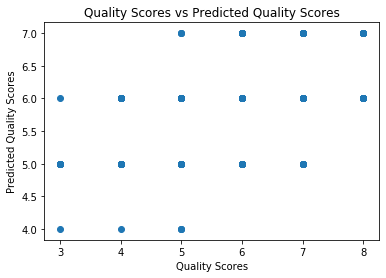

In [341]:
#not very good
plt.scatter(Y, ridge_predictions)
plt.xlabel("Quality Scores")
plt.ylabel("Predicted Quality Scores")
plt.title("Quality Scores vs Predicted Quality Scores");

In [342]:
#barely better than just ols
ridge_percent = sum(ridge_predictions==Y)/len(Y)*100
ridge_percent

59.161976235146966

Using kfold cross validation with k=5 to find best tuning parameter

In [479]:
alphas=np.arange(.01,2,.01)
kfold_indices = np.arange(0,len(X),len(X)/5)
kfold_indices = np.trunc(kfold_indices)

In [458]:
#manually splitting the data
xvalid1 = X.iloc[np.arange(kfold_indices[0],kfold_indices[1]),:]
xtrain1 = X.iloc[np.arange(kfold_indices[1],len(X)),:]
xvalid2 = X.iloc[np.arange(kfold_indices[1],kfold_indices[2]),:]
xtrain2 = X.iloc[np.arange(kfold_indices[0],kfold_indices[1]),:].append(X.iloc[np.arange(kfold_indices[2],len(X)),:])
xvalid3 = X.iloc[np.arange(kfold_indices[2],kfold_indices[3]),:]
xtrain3 = X.iloc[np.arange(kfold_indices[0],kfold_indices[2]),:].append(X.iloc[np.arange(kfold_indices[3],len(X)),:])
xvalid4 = X.iloc[np.arange(kfold_indices[3],kfold_indices[4]),:]
xtrain4 = X.iloc[np.arange(kfold_indices[0],kfold_indices[3]),:].append(X.iloc[np.arange(kfold_indices[4],len(X)),:])
xvalid5 = X.iloc[np.arange(kfold_indices[4],len(X)),:]
xtrain5 = X.iloc[np.arange(kfold_indices[0],kfold_indices[4]),:]

In [466]:
yvalid1 = Y.iloc[np.arange(kfold_indices[0],kfold_indices[1])]
ytrain1 = Y.iloc[np.arange(kfold_indices[1],len(Y))]
yvalid2 = Y.iloc[np.arange(kfold_indices[1],kfold_indices[2])]
ytrain2 = Y.iloc[np.arange(kfold_indices[0],kfold_indices[1])].append(Y.iloc[np.arange(kfold_indices[2],len(Y))])
yvalid3 = Y.iloc[np.arange(kfold_indices[2],kfold_indices[3])]
ytrain3 = Y.iloc[np.arange(kfold_indices[0],kfold_indices[2])].append(Y.iloc[np.arange(kfold_indices[3],len(Y))])
yvalid4 = Y.iloc[np.arange(kfold_indices[3],kfold_indices[4])]
ytrain4 = Y.iloc[np.arange(kfold_indices[0],kfold_indices[3])].append(Y.iloc[np.arange(kfold_indices[4],len(Y))])
yvalid5 = Y.iloc[np.arange(kfold_indices[4],len(Y))]
ytrain5 = Y.iloc[np.arange(kfold_indices[0],kfold_indices[4])]

In [474]:
def mse_cost(y_pred, y_actual):
    return np.mean((y_pred - y_actual) ** 2)

def compute_error(model, split_X_train, split_Y_train, split_X_valid, split_Y_valid):

    # Fit the model on the training split
    model.fit(split_X_train,split_Y_train)
        
    # Compute the RMSE on the validation split
    error = mse_cost(split_Y_valid,model.predict(split_X_valid))
        
    return error

In [ ]:
validation_errors=[]
for alpha in alphas:
    

In [475]:
compute_error(ridge_linear_model, xtrain1, ytrain1, xvalid1, yvalid1)

0.4443965224879461

In [291]:
kfold_indices = np.arange(0,len(X),len(X)/5)
kfold_indices = np.trunc(kfold_indices)
indx = np.arange(len(kfold_indices))
indx

array([0, 1, 2, 3, 4])

In [349]:
from sklearn.linear_model import RidgeCV
ridge_cv = RidgeCV(alphas=np.arange(.01,2,.01), fit_intercept=False, store_cv_values=True).fit(X, Y)
ridge_cv

RidgeCV(alphas=array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67...
       1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5 , 1.51, 1.52, 1.53, 1.54,
       1.55, 1.56, 1.57, 1.58, 1.59, 1.6 , 1.61, 1.62, 1.63, 1.64, 1.65,
       1.66, 1.67, 1.68, 1.69, 1.7 , 1.71, 1.72, 1.73, 1.74, 1.75, 1.76,
       1.77, 1.78, 1.79, 1.8 , 1.81, 1.82, 1.83, 1.84, 1.85, 1.86, 1.87,
       1.88, 1.89, 1.9 , 1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98,
       1.99]),
        cv=None, fit_intercept=False, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=True)

In [314]:
v1 = kfold_indices[0].astype(int)
v2 = kfold_indices[0+1].astype(int)
kfold_indices[5]

IndexError: index 5 is out of bounds for axis 0 with size 5

def compute_CV_error(model, X_train, Y_train):
    '''
    Split the training data into 4 subsets.
    For each subset, 
        fit a model holding out that subset
        compute the MSE on that subset (the validation set)
    You should be fitting 4 models total.
    Return the average MSE of these 4 folds.

    Args:
        model: an sklearn model with fit and predict functions 
        X_train (data_frame): Training data
        Y_train (data_frame): Label 

    Return:
        the average validation MSE for the 4 splits.
    '''
    validation_errors = []
    
    for idx in np.arange(len(kfold_indices)):
        # split the data
        v1 = kfold_indices[idx].astype(int)
        v2 = kfold_indices[idx+1].astype(int)
        split_X_train, split_X_valid = X.iloc[kfold_indices, ], X.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]
      
        # Fit the model on the training split
        model.fit(split_X_train, split_Y_train)
        
        error = rmse(model.predict(split_X_valid), split_Y_valid)
        # END SOLUTION

        validation_errors.append(error)
        
    return np.mean(validation_errors)

# Lasso Regression

   Given by argmin $ ||y - Xbeta||^2_2 + alpha * ||beta||_1 $ where alpha is the tuning parameter we will be finding using cross validation to minimize prediction error.

I am using scikit learn machine learning library built in lasso regression model fitting. From: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso

In [391]:
lasso_linear_model = Lasso(fit_intercept=False)
lasso_linear_model.fit(X,Y)
lasso_coef = lasso_linear_model.coef_

In [392]:
lasso_predictions = lasso_linear_model.predict(X)
lasso_predictions = np.around(lasso_predictions, decimals=0)
lasso_predictions = lasso_predictions.astype(int)
lasso_predictions

array([5, 5, 5, ..., 6, 5, 6])

In [393]:
#barely better than just ols
lasso_percent = sum(lasso_predictions==Y)/len(Y)*100
lasso_percent

55.28455284552846

# Elastic Net Regression

   Given by argmin $ ||y - Xbeta||^2_2 + alpha * ||beta||^2_2 + lambda * ||beta||_1 $ where alpha and lambda are the tuning parameters we will be finding using cross validation to minimize prediction error. Elastic net is combing the penalty functions from Lasso and Ridge regression

I am using scikit learn machine learning library built in elastic net regression model fitting. From: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [401]:
EN_linear_model =ElasticNet(fit_intercept = False)
EN_linear_model.fit(X,Y)
EN_coef = EN_linear_model.coef_
EN_coef

array([0.00000000e+00, 1.06530396e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.15331190e-03, 5.35293004e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.35823019e-01])

In [399]:
EN_predictions = EN_linear_model.predict(X)
EN_predictions = np.around(EN_predictions, decimals=0)
EN_predictions = EN_predictions.astype(int)
EN_predictions

array([5, 5, 5, ..., 6, 5, 6])

In [400]:
#barely better than just ols
EN_percent = sum(EN_predictions==Y)/len(Y)*100
EN_percent

55.65978736710444